In [67]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch
import pickle
plt.rcParams['figure.figsize'] = 15, 10

# Initializing the transform for the dataset
transform = torchvision.transforms.Compose([
	torchvision.transforms.ToTensor(),
	torchvision.transforms.Normalize((0.5), (0.5))
])








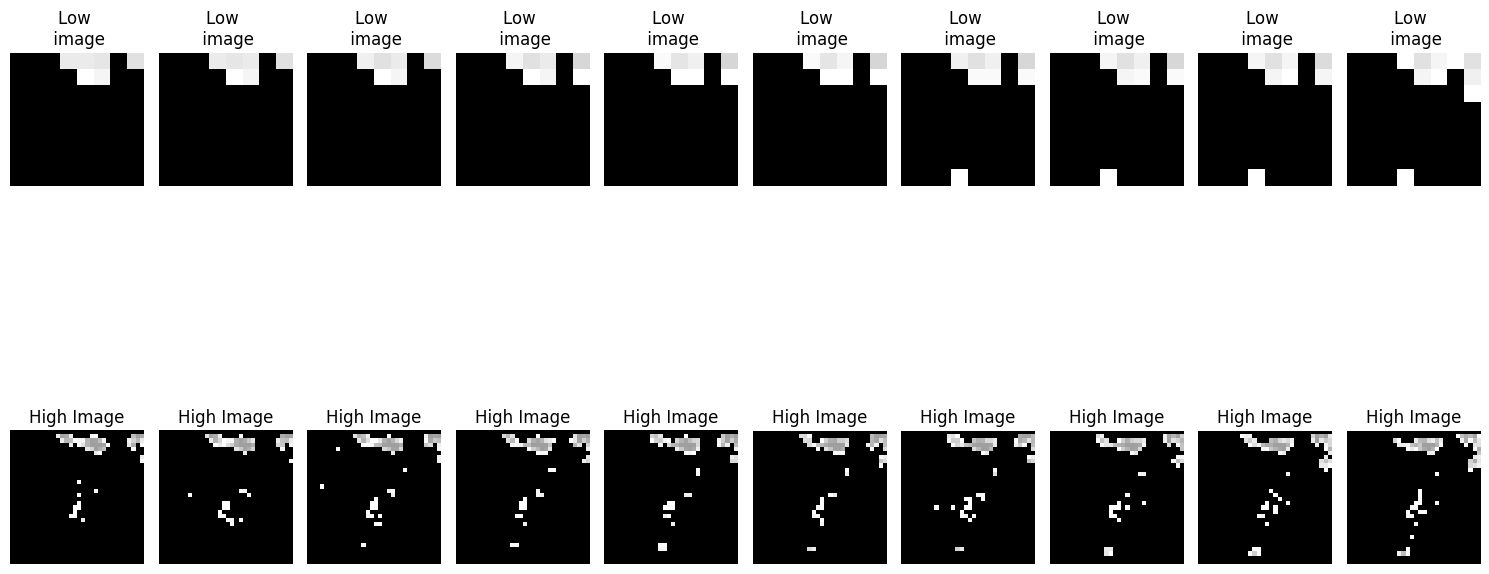

In [68]:
# load pickle file from ../data/scratch/img_pairs.pkl
with open("../../data/scratch/img_pairs.pkl", "rb") as f:
	train_dataset = pickle.load(f)

transformed_train_dataset = [(transform(image), transform(label)) for image, label in train_dataset]

n = len(transformed_train_dataset)
train_data = transformed_train_dataset[:int(n*0.9)]
val_data = transformed_train_dataset[int(n*0.9):]



counter = 1




for idx in range(10):
	idx = idx + 150
	val = transformed_train_dataset[idx][0]
	plt.subplot(2, 10, counter)
	plt.title("Low \n image")
	plt.imshow(val.reshape(8, 8), cmap='gray')
	plt.axis('off')

	# Incrementing subplot counter
	counter += 1

for idx in range(10):
    idx = idx + 150
    val = transformed_train_dataset[idx][1]
    plt.subplot(2, 10, counter)
    plt.imshow(val.reshape(32, 32), cmap='gray')
    plt.title("High Image")
    plt.axis('off')

	# Incrementing subplot counter
    counter += 1

plt.tight_layout()
plt.show()


In [69]:
# Creating a DeepAutoencoder class
class DeepAutoencoder(torch.nn.Module):
	def __init__(self):
		super().__init__()
		
		self.decoder = torch.nn.Sequential(
			torch.nn.Linear(64, 64),
			torch.nn.ReLU(),
			torch.nn.Linear(64, 128),
			torch.nn.ReLU(),
			torch.nn.Linear(128, 256),
			torch.nn.ReLU(),
			torch.nn.Linear(256, 32 * 32),
			torch.nn.Sigmoid()
		)

	
	def decode(self, x):
		return self.decoder(x)
	def forward(self, x):
		
		decoded = self.decode(x)
		return decoded

# Instantiating the model and hyperparameters
model = DeepAutoencoder()
model = model.to('cuda')
criterion = torch.nn.MSELoss()
num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [70]:
# List that will store the training loss
train_loss = []

# Dictionary that will store the
# different images and outputs for
# various epochs
outputs = {}

batch_size = len(train_data)

b2 = []

for batch in train_data:
			
		# Loading image(s) and
		# reshaping it into a 1-d vector
		img, img2 = batch
		img = img.to('cuda')
		img2 = img2.to('cuda')
		b2.append((img, img2))
# Training loop starts
for epoch in range(num_epochs):
	
	# Initializing variable for storing
	# loss
	running_loss = 0
	
	# Iterating over the training dataset
	for batch in b2:
			
		# Loading image(s) and
		# reshaping it into a 1-d vector
		img = batch[0]
		img_label = batch[1]
		#img = img.to('cuda')
		img = img.reshape(-1, 8*8)
		img_label = img_label.reshape(-1, 32*32)
		# Generating output
		out = model(img)
		
		# Calculating loss
		loss = criterion(out, img_label)
		
		# Updating weights according
		# to the calculated loss
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Incrementing loss
		running_loss += loss.item()
	
	# Averaging out loss over entire batch
	running_loss /= batch_size
	train_loss.append(running_loss)
	print(f"{running_loss} {epoch}")
	# Storing useful images and
	# reconstructed outputs for the last batch
	outputs[epoch+1] = {'img': img, 'out': out}





1.0683628491471322 0
0.9815044456653381 1
0.9815044382984719 2
0.9815044376287567 3
0.9815044376287567 4
0.9815044372938992 5
0.9815044342801812 6
0.9807460190874807 7
0.9805430096856663 8
0.9802503106969126 9
0.9802502902706017 10
0.9802502872568838 11
0.9802502872568838 12
0.9802502875917414 13
0.9802502865871686 14
0.9802502865871686 15
0.9802502875917414 16
0.9802502865871686 17
0.9802502865871686 18
0.9802502875917414 19
0.9802502865871686 20
0.9802502869220262 21
0.9802502869220262 22
0.9836077053895157 23
0.9816077636199051 24
0.9800454431705261 25
0.9800426665316807 26
0.9800460301758198 27
0.9800460408912616 28
0.9800460335243953 29
0.9800460291712472 30
0.980046025487814 31
0.9800460164466601 32
0.9800459926717737 33
0.9800451873393541 34
0.9800459866443377 35
0.9800429297297188 36
0.9841529549507613 37
0.9857510030269623 38
0.9853395545080806 39
0.985337711786956 40
0.985337711786956 41
0.985337711786956 42
0.985337711786956 43
0.985337711786956 44
0.985337711786956 45
0.985

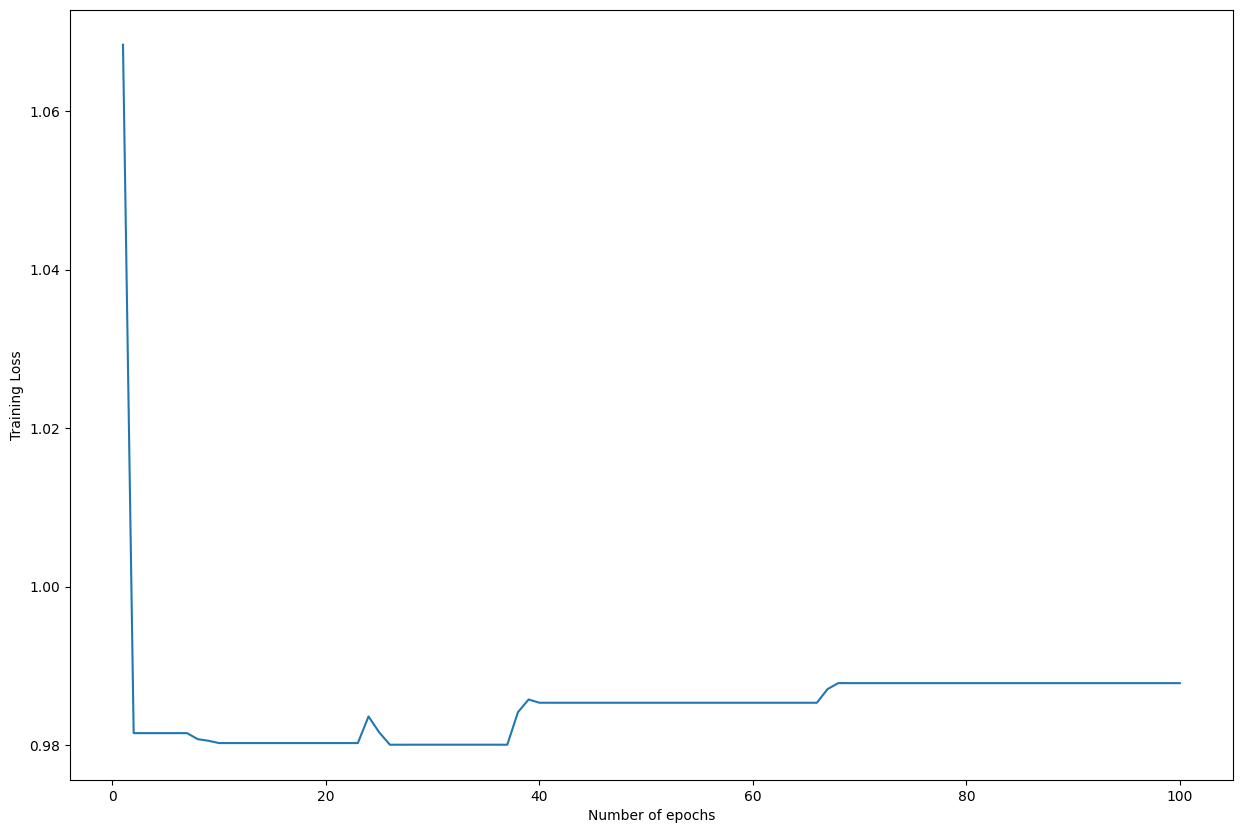

In [71]:
# Plotting the training loss
plt.plot(range(1,num_epochs+1),train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()

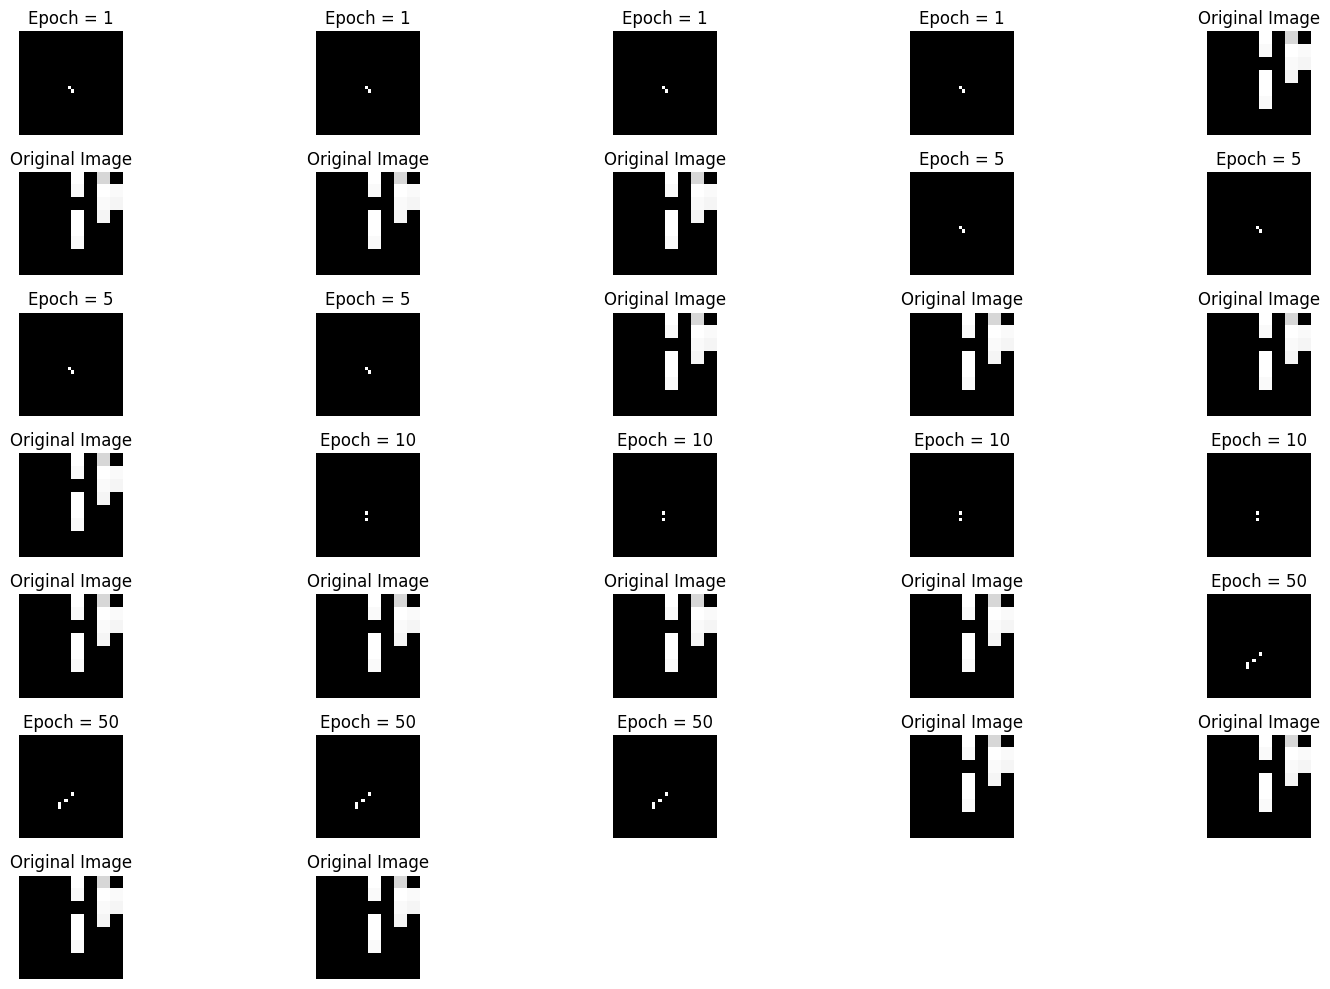

In [72]:
# Plotting is done on a 7x5 subplot
# Plotting the reconstructed images

# Initializing subplot counter
counter = 1

# Plotting reconstructions
# for epochs = [1, 5, 10, 50, 100]
epochs_list = [1, 5, 10, 50]

# Iterating over specified epochs
for val in epochs_list:
	
	# Extracting recorded information
	temp = outputs[val]['out'].detach().cpu().numpy()
	title_text = f"Epoch = {val}"
	
	# Plotting first five images of the last batch
	for idx in range(4):
		plt.subplot(7, 5, counter)
		plt.title(title_text)
		plt.imshow(temp.reshape(32,32), cmap= 'gray')
		plt.axis('off')
		
		# Incrementing the subplot counter
		counter+=1

	# Plotting original images

	# Iterating over first five
	# images of the last batch
	for idx in range(4):
		
		# Obtaining image from the dictionary
		
		temp = outputs[val]['img'].detach().cpu().numpy()
		# Plotting image
		plt.subplot(7,5,counter)
		plt.imshow(temp.reshape(8, 8),
				cmap = 'gray')
		plt.title("Original Image")
		plt.axis('off')
		
		# Incrementing subplot counter
		counter+=1

plt.tight_layout()
plt.show()


ValueError: num must be an integer with 1 <= num <= 20, not 21

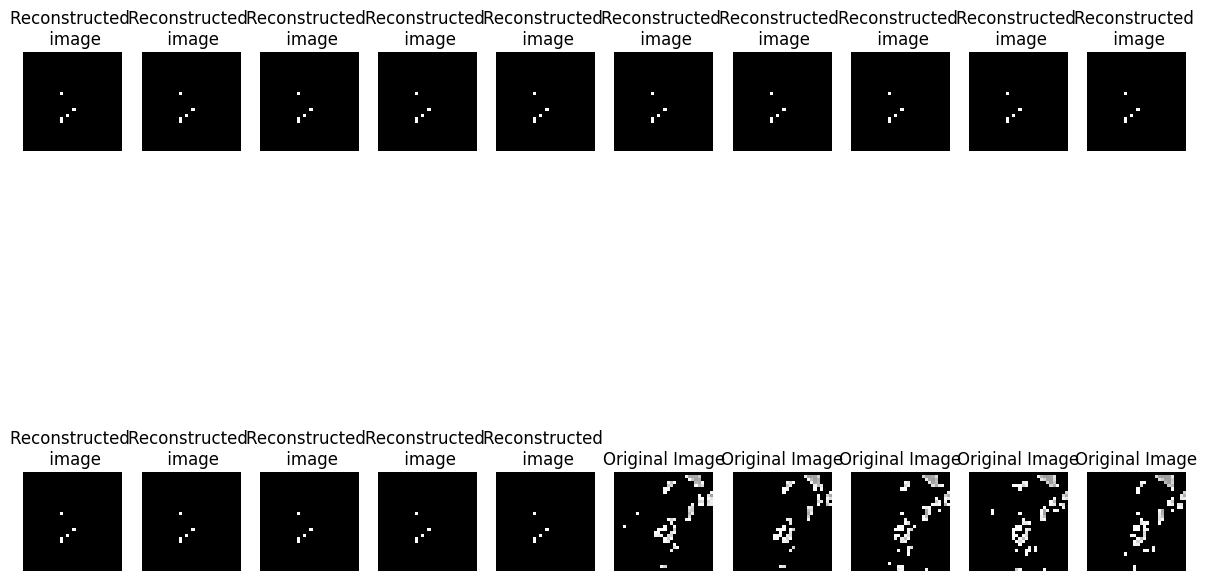

In [102]:
# Dictionary that will store the different
# images and outputs for various epochs
outputs = {}

# Extracting the last batch from the test
# dataset
validation_data = val_data[:5]

scored_images = []


for val_item in val_data:	
	
	to_score = val_item[0].reshape(-1, 8*8)
	to_score = to_score.to('cuda')
	scored = model.decode(to_score)
	
	scored_images.append((val_item[1], scored))


# Generating output for the obtained
# batch


counter = 1


# Plotting first 10 images of the batch
for idx in range(len(validation_data)):
	plt.subplot(2, 10, counter)
	plt.title("Reconstructed \n image")
	plt.imshow(scored_images[idx][1].cpu().detach().reshape(32, 32), cmap='gray')
	plt.axis('off')

	# Incrementing subplot counter
	counter += 1

# Plotting original images

# Plotting first 10 images
for idx in range(len(validation_data)):
    
    plt.subplot(2, 10, counter)
    plt.imshow(scored_images[idx][0].reshape(32, 32), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

	# Incrementing subplot counter
    counter += 1

plt.tight_layout()
plt.show()


In [ ]:
torch.save(model.state_dict(), 'RADAR_UPSCALER.pth')

In [ ]:
model2 = DeepAutoencoder()
model2.load_state_dict(torch.load('RADAR_UPSCALER.pth'))
model2 = model.to('cuda')  # Don't forget to move the model to GPU if available